In [1]:
# %%bash

# pip install tensorflow
# pip install keras
# !pip install scikit-learn

In [2]:
import keras
from keras import applications
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn import metrics

from slideslicer import RoiReader
import slideslicer as slsl

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn import metrics

In [4]:
model_wo_top = applications.ResNet50(weights="imagenet", include_top=False)

In [5]:
for lyr in model_wo_top.layers:
    lyr.trainable=False

In [13]:
zzz = layers.GlobalAveragePooling2D()(model_wo_top.layers[-1].output)
logits = layers.Dense(1, activation='sigmoid')(zzz)
model = keras.models.Model(model_wo_top.inputs, logits)

In [14]:
data_dir_train = 'patches/train/'
data_dir_val = 'patches/val/'

In [15]:
model.compile(optimizer=Adam(lr=4e-4), loss='binary_crossentropy')

In [9]:
from keras.applications.resnet50 import preprocess_input

In [27]:
# I would resize the image to that of the standard input size of ResNet50.
datagen_train = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   zoom_range = (0.9,1.1),
                                   shear_range=0.04,
                                  )
batch_size = 16
generator_train = datagen_train.flow_from_directory(
    data_dir_train,
#     target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

Found 476 images belonging to 2 classes.


In [17]:
# I would resize the image to that of the standard input size of ResNet50.
datagen_val = ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 16
generator_val = datagen_val.flow_from_directory(
    data_dir_val,
#     target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
)

Found 107 images belonging to 2 classes.


In [18]:
model.fit_generator(generator_train, epochs=10,
                    steps_per_epoch=len(generator_train),
                    validation_data=generator_val,
                    validation_steps=len(generator_val))

Epoch 1/10
30/30 [==============================] - 12s 404ms/step - loss: 0.6586 - val_loss: 0.5895
Epoch 2/10
30/30 [==============================] - 10s 333ms/step - loss: 0.4792 - val_loss: 0.5257
Epoch 3/10
30/30 [==============================] - 11s 376ms/step - loss: 0.3883 - val_loss: 0.4693
Epoch 4/10
30/30 [==============================] - 10s 327ms/step - loss: 0.3653 - val_loss: 0.4375
Epoch 5/10
30/30 [==============================] - 11s 381ms/step - loss: 0.3292 - val_loss: 0.4006
Epoch 6/10
30/30 [==============================] - 11s 360ms/step - loss: 0.2927 - val_loss: 0.3792
Epoch 7/10
30/30 [==============================] - 11s 362ms/step - loss: 0.2773 - val_loss: 0.3573
Epoch 8/10
30/30 [==============================] - 10s 329ms/step - loss: 0.2552 - val_loss: 0.3391
Epoch 9/10
30/30 [==============================] - 11s 377ms/step - loss: 0.2634 - val_loss: 0.3329
Epoch 10/10
30/30 [==============================] - 10s 328ms/step - loss: 0.2499 - val_lo

In [33]:
for lyr in model.layers:
    lyr.trainable=True
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy')

In [84]:
model.fit_generator(generator_train, epochs=20,
                    steps_per_epoch=len(generator_train),
                    validation_data=generator_val,
                    validation_steps=len(generator_val))

## Assess performance in the validation set

In [87]:
yhat = model.predict_generator(generator_val, steps=len(generator_val))

In [37]:
metrics.accuracy_score(generator_val.classes, yhat>0.5)

0.8878504672897196

In [38]:
metrics.roc_auc_score(generator_val.classes, yhat>0.5)

0.8202983725135624

In [88]:
metrics.average_precision_score(generator_val.classes, yhat.ravel())

0.9812092217893129

## Save weights

In [39]:
model.save_weights('../data/resnet50_mouse_gloms_scale4.h5')

## Perform inference on the whole slide

In [32]:
model.load_weights('../data/resnet50_mouse_gloms_scale4.h5')

In [78]:
fnxml  = "../data/14112.xml"

rreader = RoiReader(fnxml, threshold_tissue=True,
                    verbose=True, # prints out counts of ROIs below 
                   )

patch_iterator = slsl.PatchIterator(rreader, vertices=rreader.df_tissue.vertices.iloc[0],
                   points=None, side=256,
                   subsample=8, batch_size=4, preprocess=lambda x: preprocess_input(x.astype('float32')),
                   oversample=4, mode='grid' )

---------------
counts of ROIs
---------------
glom      100
tissue      5
dtype: int64
---------------------------------------------
counts of ROIs after removing empty chunks
---------------------------------------------
glom      99
tissue     1
dtype: int64


In [79]:
yhat = model.predict_generator(patch_iterator, steps=len(patch_iterator))

In [47]:
# for img, xy in patch_iterator:
#     break

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([209.,  40.,  28.,  18.,  17.,  14.,   8.,  21.,  29., 346.]),
 array([0.00246996, 0.10220637, 0.20194278, 0.30167919, 0.4014156 ,
        0.50115201, 0.60088842, 0.70062483, 0.80036124, 0.90009765,
        0.99983406]),
 <a list of 10 Patch objects>)

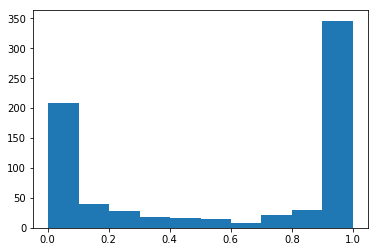

In [81]:
# dir(patch_iterator)
plt.hist(yhat.ravel())

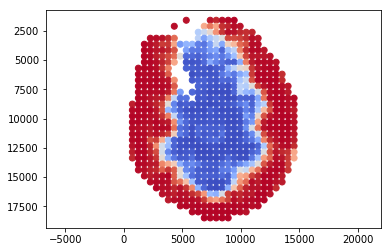

In [82]:
plt.scatter(patch_iterator.points[:,0], 
            patch_iterator.points[:,1],
            c=yhat.ravel(),
            cmap='coolwarm')
plt.axis('equal');
plt.gca().invert_yaxis() # y=0 is on top for images

(<matplotlib.figure.Figure at 0x7f7bbd0195c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7bba16f7f0>)

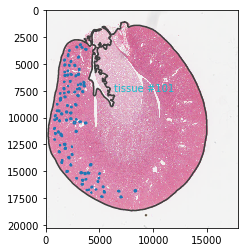

In [83]:
rreader.plot()